In [38]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import regularizers

In [53]:
# Define constants
IMAGE_SIZE = (180, 180)
BATCH_SIZE = 120
EPOCHS = 25
NUM_CLASSES = 1

In [40]:
# Define data augmentation pipeline
data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.1),
        layers.RandomBrightness(0.1),
])

In [41]:
# Load data
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    'Data/PetImages',
    validation_split=0.2,
    subset='both',
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


In [42]:
# Apply data augmentation to training set
train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

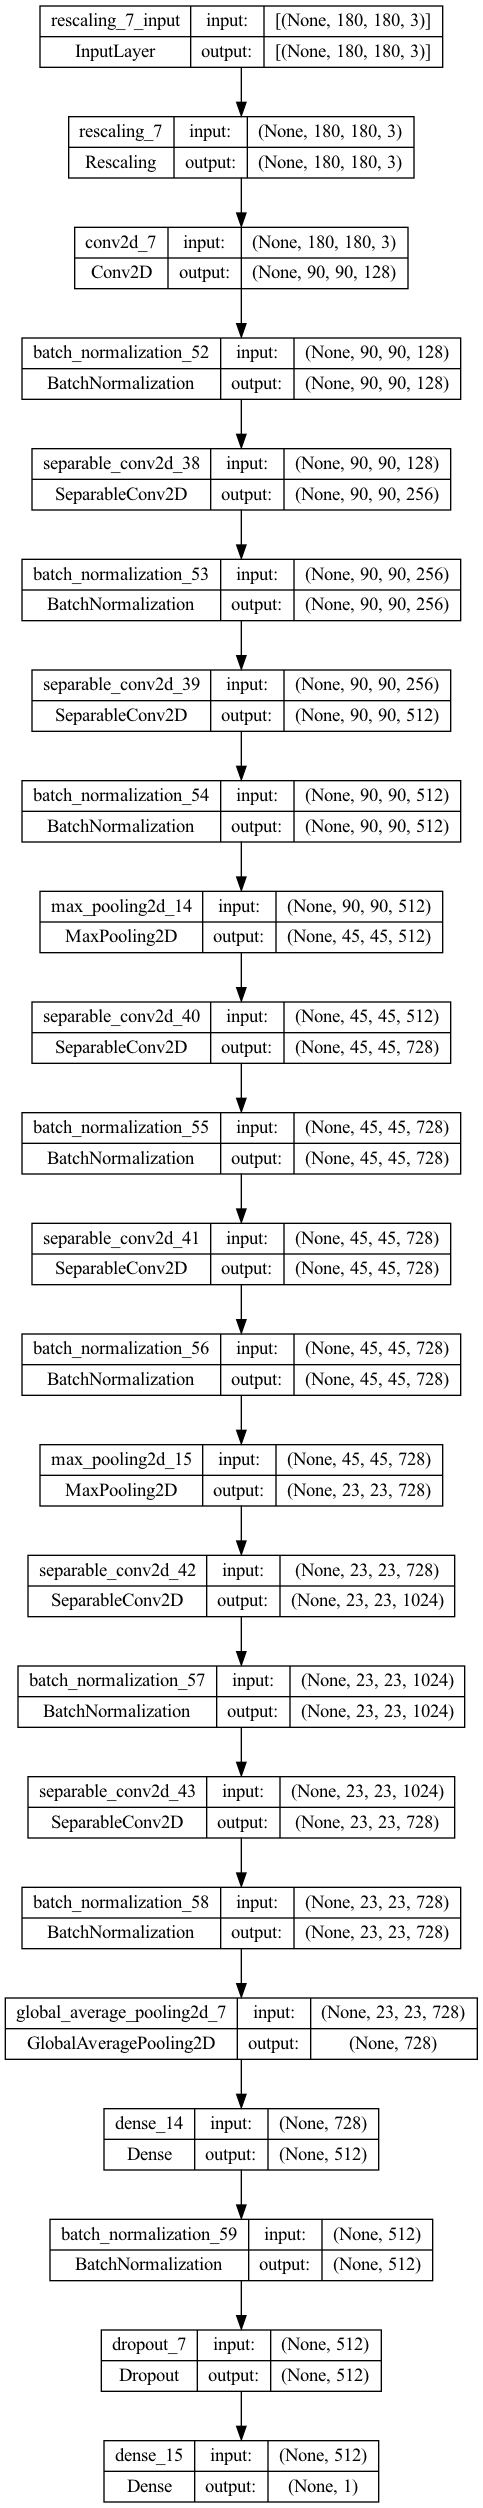

In [58]:
# Define the model
model = keras.Sequential([
    layers.Rescaling(1./255, input_shape=IMAGE_SIZE+(3,)),
    layers.Conv2D(128, 3, strides=2, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.SeparableConv2D(256, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.SeparableConv2D(512, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(3, strides=2, padding='same'),
    layers.SeparableConv2D(728, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.SeparableConv2D(728, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(3, strides=2, padding='same'),
    layers.SeparableConv2D(1024, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.SeparableConv2D(728, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

keras.utils.plot_model(model, show_shapes=True)

In [54]:
# Compile the model
model.compile(
    optimizer=keras.optimizers.legacy.Adam(1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Train the model
callbacks = [keras.callbacks.ModelCheckpoint('save_at_{epoch}.keras')]
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data=val_ds
)

In [57]:
# Make predictions on test image
test_image_path = 'test.jpg'
test_image = keras.preprocessing.image.load_img(test_image_path, target_size=IMAGE_SIZE)
test_image_array = keras.preprocessing.image.img_to_array(test_image)
test_image_array = tf.expand_dims(test_image_array, 0)
predictions = model.predict(test_image_array)
score = float(predictions[0])
print(f'This image is {100*(1-score):.2f}% cat and {100*score:.2f}% dog.')

1/1 [==============================] - 0s 400ms/step
This image is 99.96% cat and 0.04% dog.
